In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
from pathlib import Path
from importlib import reload
import pandas as pd
import matplotlib
import numpy as np
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt

from src.constants import PROCESSED_POLCOM_DATA_2022_M_PATH, PROCESSED_POLCOM_DATA_2022_Y_PATH, PROCESSED_AZURE_DATA_PATH
from src.utils import concat_dataframes_horizontally

In [271]:
dfs_M = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_M_PATH).glob("*.parquet")}
dfs_Y = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_Y_PATH).glob("*.parquet")}

In [272]:
for vm, df in dfs_M.items():
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    print(df.columns)

Index(['CPU_USAGE_MHZ', 'CPU_USAGE_PERCENT', 'MEMORY_USAGE_KB',
       'MEMORY_USAGE_PERCENT', 'NODE_1_DISK_IO_RATE_KBPS',
       'NODE_1_DISK_I_RATE_KBPS', 'NODE_1_DISK_O_RATE_KBPS',
       'df3_NODE_1_DISK_IO_RATE_KBPS', 'df3_NODE_1_DISK_I_RATE_KBPS',
       'df3_NODE_1_DISK_O_RATE_KBPS', 'NODE_2_DISK_IO_RATE_KBPS',
       'NODE_2_DISK_I_RATE_KBPS', 'NODE_2_DISK_O_RATE_KBPS',
       'df5_NODE_2_DISK_IO_RATE_KBPS', 'df5_NODE_2_DISK_I_RATE_KBPS',
       'df5_NODE_2_DISK_O_RATE_KBPS', 'NODE_3_DISK_IO_RATE_KBPS',
       'NODE_3_DISK_I_RATE_KBPS', 'NODE_3_DISK_O_RATE_KBPS',
       'df7_NODE_3_DISK_IO_RATE_KBPS', 'df7_NODE_3_DISK_I_RATE_KBPS',
       'df7_NODE_3_DISK_O_RATE_KBPS', 'NODE_4_DISK_IO_RATE_KBPS',
       'NODE_4_DISK_I_RATE_KBPS', 'NODE_4_DISK_O_RATE_KBPS',
       'df9_NODE_4_DISK_IO_RATE_KBPS', 'df9_NODE_4_DISK_I_RATE_KBPS',
       'df9_NODE_4_DISK_O_RATE_KBPS', 'NODE_1_NETWORK_TR_KBPS',
       'NODE_1_NETWORK_R_RATE_KBPS', 'NODE_1_NETWORK_T_RATE_KBPS',
       'df11_NODE_1_NETW

In [273]:
# Function to aggregate DISK_IO and NETWORK_TR metrics across all nodes
def aggregate_metrics(df):
    """Aggregates DISK_IO and NETWORK_TR across all nodes."""
    # Identify relevant columns
    disk_io_cols = [col for col in df.columns if "DISK_IO_RATE_KBPS" in col]
    network_tr_cols = [col for col in df.columns if "NETWORK_TR_KBPS" in col]

    # Aggregate by computing the mean across all nodes
    df["AVG_DISK_IO_RATE_KBPS"] = df[disk_io_cols].mean(axis=1) if disk_io_cols else np.nan
    df["AVG_NETWORK_TR_KBPS"] = df[network_tr_cols].mean(axis=1) if network_tr_cols else np.nan

    # Keep only the required columns
    selected_columns = ["CPU_USAGE_MHZ", "MEMORY_USAGE_KB", "AVG_DISK_IO_RATE_KBPS", "AVG_NETWORK_TR_KBPS"]
    return df[selected_columns]

# Apply aggregation to all datasets
aggregated_dfs_M = {vm: aggregate_metrics(df) for vm, df in dfs_M.items()}
aggregated_dfs_M

{'VM06.parquet':                      CPU_USAGE_MHZ  MEMORY_USAGE_KB  AVG_DISK_IO_RATE_KBPS  \
 DATE                                                                         
 2021-04-14 00:00:00            NaN              NaN               14758.00   
 2021-04-15 00:00:00            NaN              NaN               15858.50   
 2021-04-16 00:00:00            NaN              NaN               10896.00   
 2021-04-17 00:00:00            NaN              NaN               19679.25   
 2021-04-18 00:00:00            NaN              NaN               20975.00   
 ...                            ...              ...                    ...   
 2022-04-13 02:00:00        33106.0      119437616.0               26100.00   
 2022-04-13 04:00:00        37600.0      129820016.0               15995.00   
 2022-04-13 06:00:00        59916.0      185327216.0               10088.00   
 2022-04-13 08:00:00            0.0              0.0                   0.00   
 2022-04-13 10:00:00            0.0 

In [274]:
aggregated_dfs_M['VM06.parquet']

,CPU_USAGE_MHZ,MEMORY_USAGE_KB,AVG_DISK_IO_RATE_KBPS,AVG_NETWORK_TR_KBPS
DATE,,,,
2021-04-14 00:00:00,NaN,NaN,14758.00,4179.00
2021-04-15 00:00:00,NaN,NaN,15858.50,7191.75
2021-04-16 00:00:00,NaN,NaN,10896.00,6424.25
2021-04-17 00:00:00,NaN,NaN,19679.25,3562.25
2021-04-18 00:00:00,NaN,NaN,20975.00,5050.75
...,...,...,...,...
2022-04-13 02:00:00,33106.0,119437616.0,26100.00,14999.50
2022-04-13 04:00:00,37600.0,129820016.0,15995.00,29607.75
2022-04-13 06:00:00,59916.0,185327216.0,10088.00,24484.50


In [275]:
# Function to trim dataset based only on CPU column, treating 0 as NaN
def trim_based_on_cpu(df):
    """Removes leading and trailing rows where the CPU column is NaN or 0, preserving all other columns."""
    df_replaced = df.copy()
    df_replaced["CPU_USAGE_MHZ"] = df_replaced["CPU_USAGE_MHZ"].replace(0, np.nan)  # Treat 0 as NaN only for CPU

    # Find the first and last valid index where CPU_USAGE_MHZ is not NaN or 0
    first_valid_idx = df_replaced["CPU_USAGE_MHZ"].dropna().first_valid_index()
    last_valid_idx = df_replaced["CPU_USAGE_MHZ"].dropna().last_valid_index()

    # If the entire CPU column is NaN or zeros, return an empty DataFrame
    if first_valid_idx is None or last_valid_idx is None:
        return pd.DataFrame(columns=df.columns)

    return df.loc[first_valid_idx:last_valid_idx]

# Apply trimming based on CPU column to each dataset
trimmed_dfs_M = {vm: trim_based_on_cpu(df) for vm, df in aggregated_dfs_M.items()}

# Verify results: Check the first and last timestamps after trimming
trim_summary = {vm: (df.index.min(), df.index.max(), df.isna().sum().sum()) for vm, df in trimmed_dfs_M.items()}

# Display summary of trimmed datasets
trim_summary

{'VM06.parquet': (Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 06:00:00'),
  0),
 'VM03.parquet': (Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00'),
  0),
 'VM07.parquet': (Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 06:00:00'),
  3),
 'VM08.parquet': (Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 04:00:00'),
  0),
 'VM04.parquet': (Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00'),
  0),
 'VM01.parquet': (Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 08:00:00'),
  0),
 'VM02.parquet': (Timestamp('2022-03-14 14:00:00'),
  Timestamp('2022-04-13 08:00:00'),
  0),
 'VM05.parquet': (Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00'),
  346)}

In [276]:
trimmed_dfs_M

{'VM06.parquet':                      CPU_USAGE_MHZ  MEMORY_USAGE_KB  AVG_DISK_IO_RATE_KBPS  \
 DATE                                                                         
 2022-03-14 12:00:00        58567.0      237844016.0               10461.00   
 2022-03-14 14:00:00        41881.0      207525728.0               25635.50   
 2022-03-14 16:00:00        31048.0      193391552.0                5960.00   
 2022-03-14 18:00:00        34468.0      181506208.0               33570.50   
 2022-03-14 20:00:00        31933.0      152235904.0               21753.75   
 ...                            ...              ...                    ...   
 2022-04-12 22:00:00        35485.0      141953184.0               38674.00   
 2022-04-13 00:00:00        40423.0      162135408.0               45198.75   
 2022-04-13 02:00:00        33106.0      119437616.0               26100.00   
 2022-04-13 04:00:00        37600.0      129820016.0               15995.00   
 2022-04-13 06:00:00        59916.0 

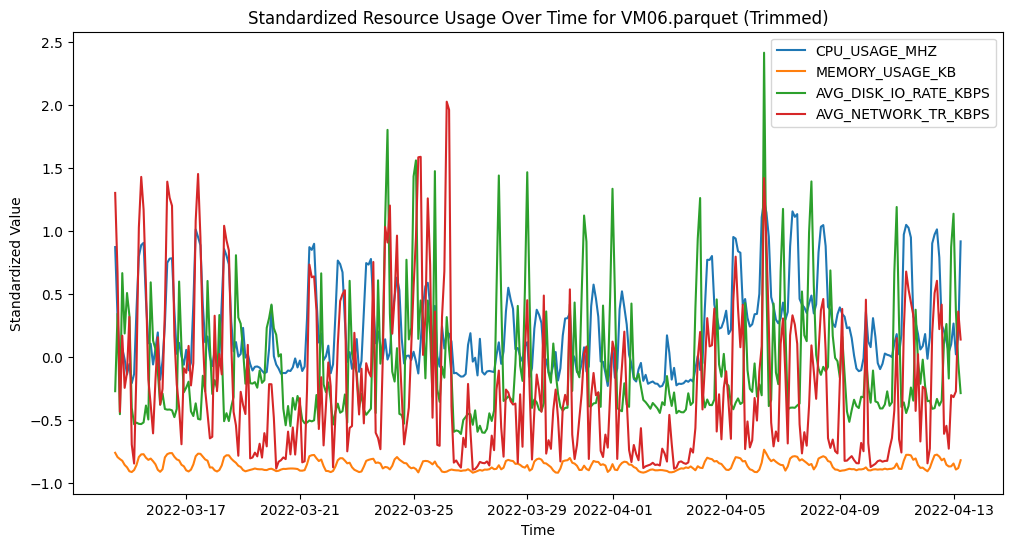

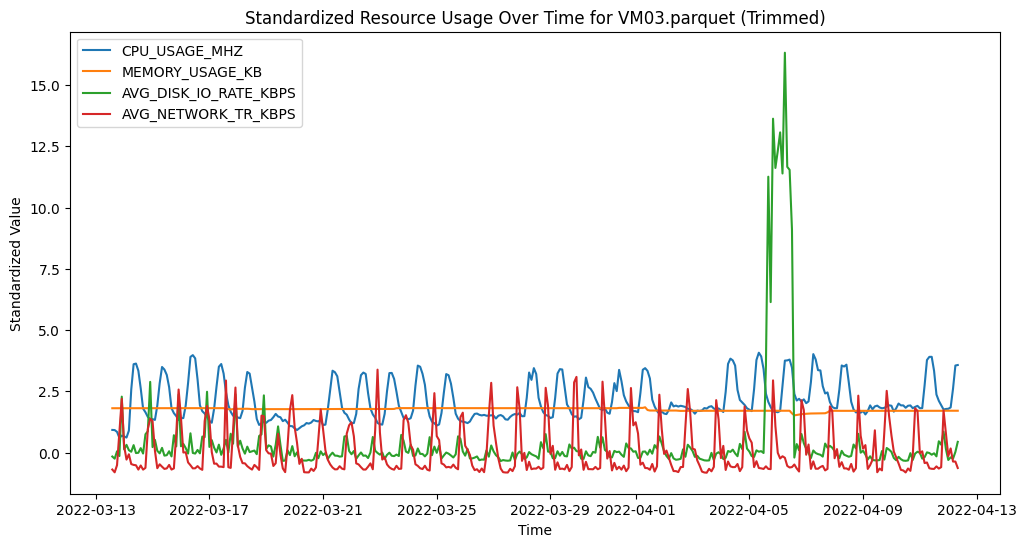

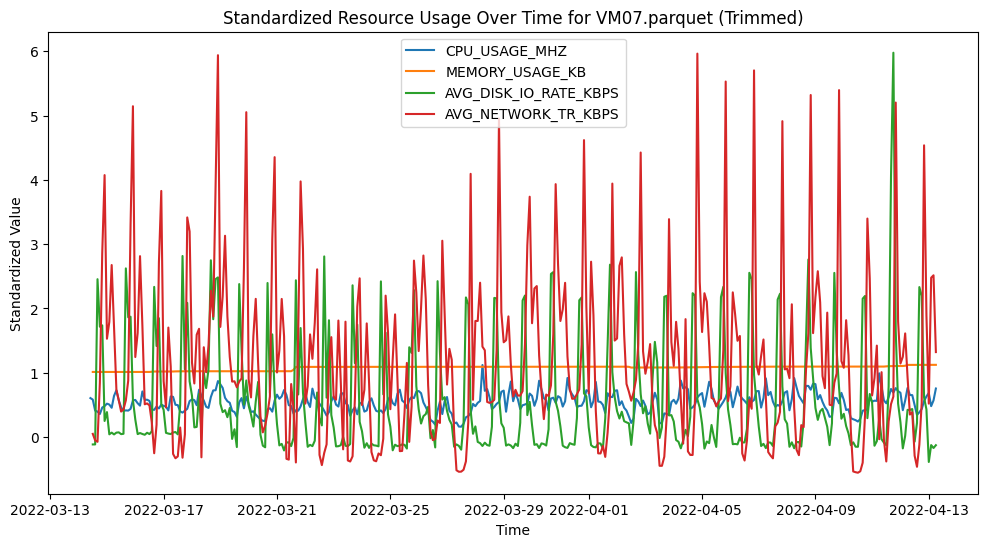

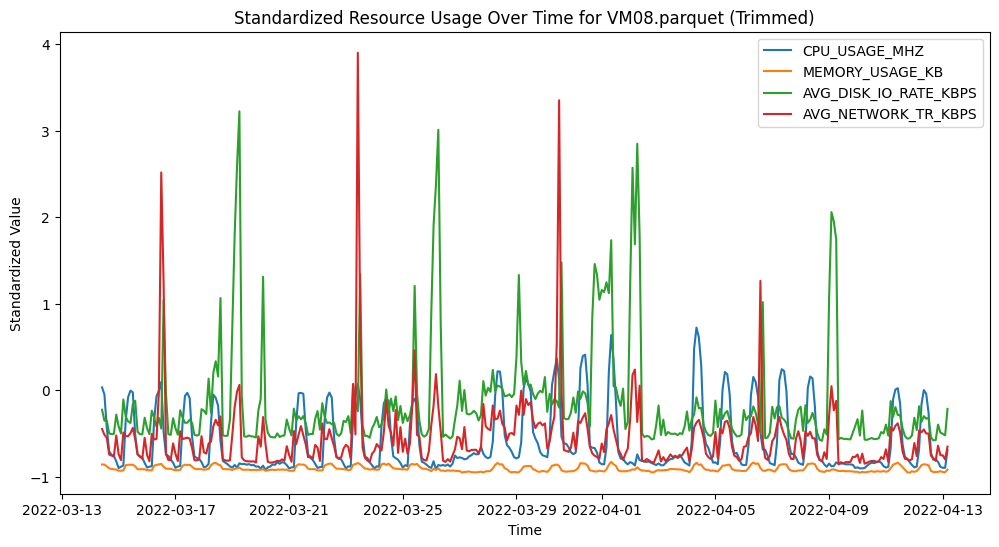

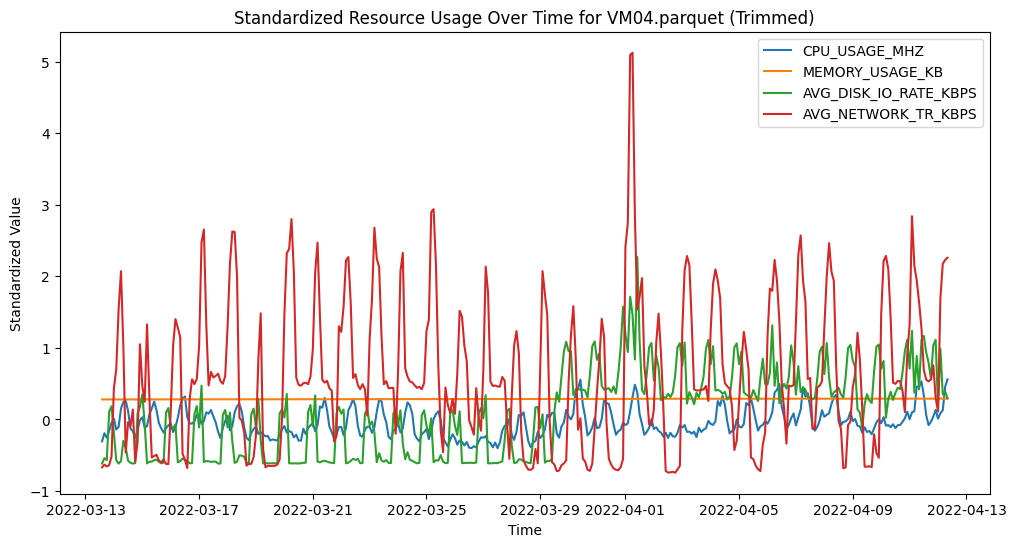

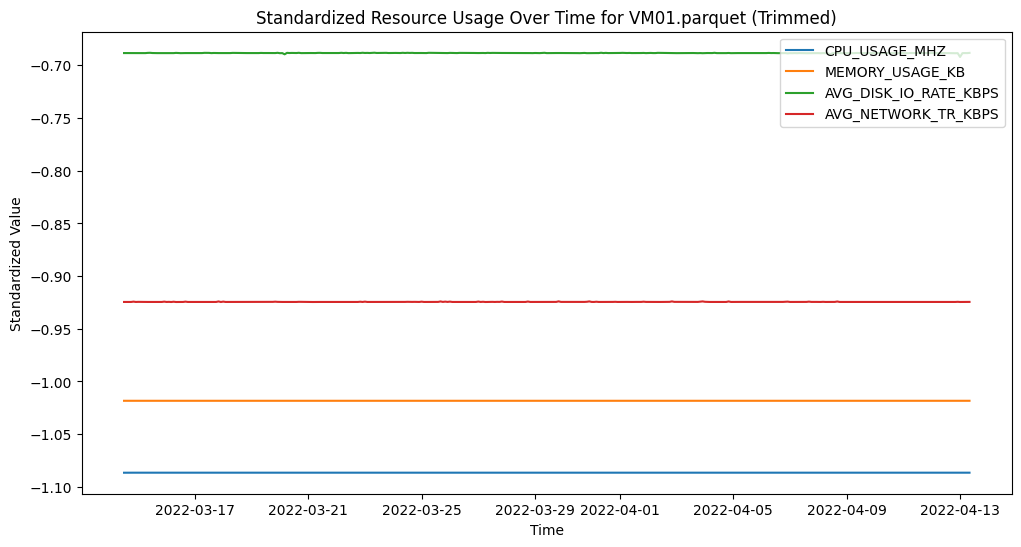

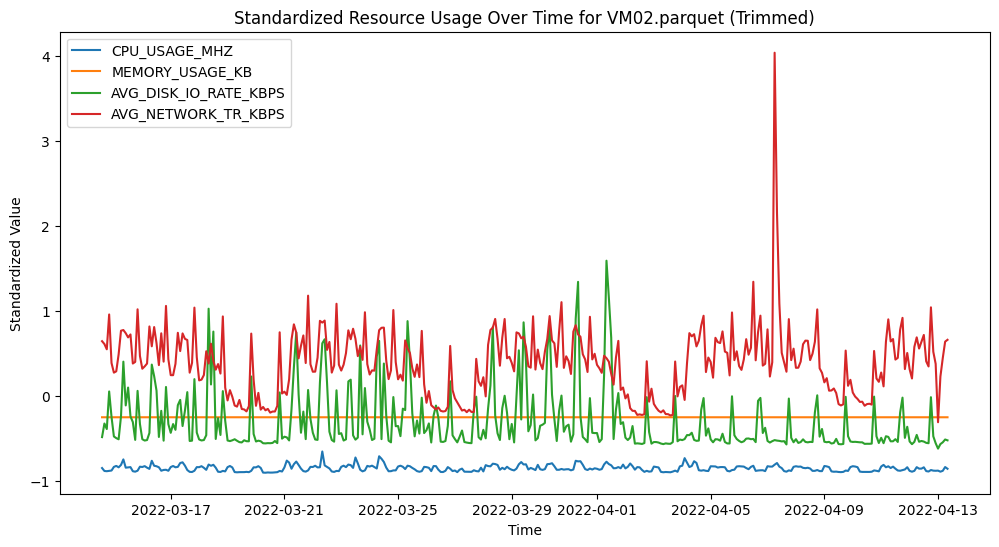

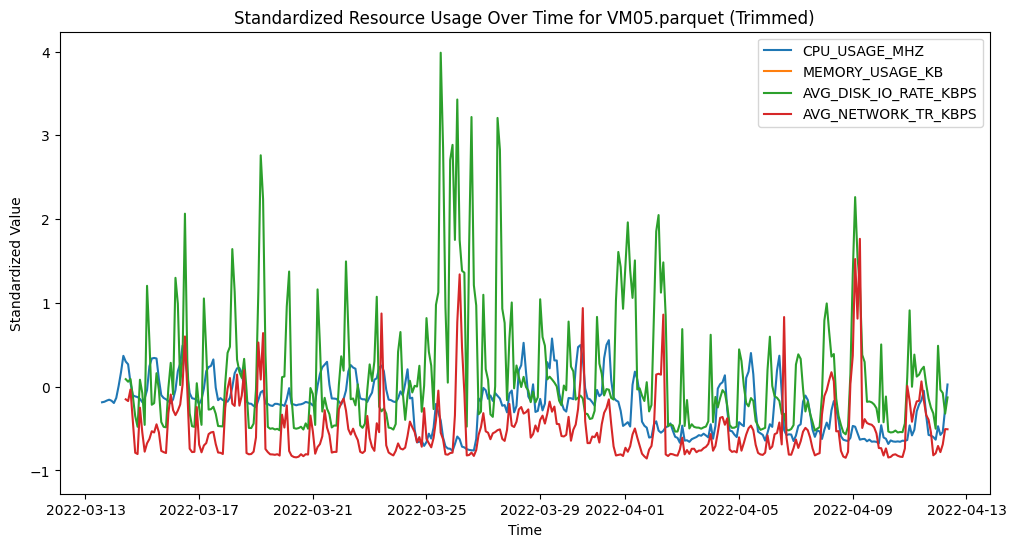

In [277]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_data = pd.concat(trimmed_dfs_M.values())  # Combine all VMs' data for global fitting
scaler.fit(all_data)  # Fit once globally

standardized_dfs_M = {
    vm: pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    for vm, df in trimmed_dfs_M.items()
}
# Plot each VM's standardized dataset with all columns
for vm, df in standardized_dfs_M.items():
    plt.figure(figsize=(12, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    plt.xlabel("Time")
    plt.ylabel("Standardized Value")
    plt.title(f"Standardized Resource Usage Over Time for {vm} (Trimmed)")
    plt.legend()
    plt.show()


In [278]:
standardized_dfs_M['VM01.parquet']

,CPU_USAGE_MHZ,MEMORY_USAGE_KB,AVG_DISK_IO_RATE_KBPS,AVG_NETWORK_TR_KBPS
DATE,,,,
2022-03-14 12:00:00,-1.086577,-1.018319,-0.688380,-0.924540
2022-03-14 14:00:00,-1.086544,-1.018319,-0.688380,-0.924540
2022-03-14 16:00:00,-1.086544,-1.018319,-0.688299,-0.924540
2022-03-14 18:00:00,-1.086544,-1.018320,-0.688380,-0.924540
2022-03-14 20:00:00,-1.086544,-1.018319,-0.688340,-0.924236
...,...,...,...,...
2022-04-13 00:00:00,-1.086544,-1.018319,-0.692053,-0.924562
2022-04-13 02:00:00,-1.086544,-1.018319,-0.688462,-0.924540
2022-04-13 04:00:00,-1.086544,-1.018319,-0.688380,-0.924496


In [279]:
# Define a threshold for the maximum number of NaN values allowed
max_nans_threshold = 0

# Iterate over the datasets and remove those with too many NaN values
for i, (vm, df) in enumerate(list(standardized_dfs_M.items()), 1):
    num_nans = df.isna().sum().sum() 
    if num_nans > max_nans_threshold:
        del standardized_dfs_M[vm]
        print(f"Dataset {i}: Removed {num_nans} NaN values")
    else:
        print(f"Dataset {i}: {num_nans} NaN values")

Dataset 1: 0 NaN values
Dataset 2: 0 NaN values
Dataset 3: Removed 3 NaN values
Dataset 4: 0 NaN values
Dataset 5: 0 NaN values
Dataset 6: 0 NaN values
Dataset 7: 0 NaN values
Dataset 8: Removed 346 NaN values


In [280]:
len(standardized_dfs_M)

6

In [281]:
standardized_dfs_M

{'VM06.parquet':                      CPU_USAGE_MHZ  MEMORY_USAGE_KB  AVG_DISK_IO_RATE_KBPS  \
 DATE                                                                         
 2022-03-14 12:00:00       0.873370        -0.760606              -0.271264   
 2022-03-14 14:00:00       0.314915        -0.794641               0.344449   
 2022-03-14 16:00:00      -0.047649        -0.810508              -0.453895   
 2022-03-14 18:00:00       0.066814        -0.823850               0.666415   
 2022-03-14 20:00:00      -0.018029        -0.856709               0.186945   
 ...                            ...              ...                    ...   
 2022-04-12 22:00:00       0.100851        -0.868252               0.873492   
 2022-04-13 00:00:00       0.266118        -0.845596               1.138237   
 2022-04-13 02:00:00       0.021230        -0.893528               0.363296   
 2022-04-13 04:00:00       0.171637        -0.881873              -0.046719   
 2022-04-13 06:00:00       0.918519 

In [282]:
NUMBER_OF_DAILY_TIME_STEPS = 12
def create_multi_feature_sequences(data, seq_length=NUMBER_OF_DAILY_TIME_STEPS, forecast_horizon=NUMBER_OF_DAILY_TIME_STEPS):
    """Convert multi-feature time series into sequences for multi-step forecasting."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data.iloc[i:i+seq_length].values)  # Multi-feature input
        y.append(data.iloc[i+seq_length:i+seq_length+forecast_horizon].values)  # Predict all features
    return np.array(X), np.array(y)

SEQ_LENGTH = NUMBER_OF_DAILY_TIME_STEPS * 7
FORECAST_HORIZON = NUMBER_OF_DAILY_TIME_STEPS * 7

X_train_list, y_train_list = [], []

for vm, df in standardized_dfs_M.items():  # Use the dataset after trimming
    df_scaled = pd.DataFrame(df, index=df.index, columns=df.columns)  # Preserve column names

    X, y = create_multi_feature_sequences(df, SEQ_LENGTH, FORECAST_HORIZON)

    X_train_list.append(X)
    y_train_list.append(y)

# Combine all sequences into a single training dataset
X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)

print("Final Training Shape:", X_train.shape, y_train.shape)


Final Training Shape: (1147, 84, 4) (1147, 84, 4)


In [283]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Masking, BatchNormalization
# Define constants
NUM_FEATURES = 4  # Number of input/output features

# Define model function
def build_cnn_lstm_model(num_features=NUM_FEATURES):
    """Builds a CNN-LSTM model with optional inputs (handles missing features)."""

    # Input Layer (Optional: Can have missing values handled by Masking)
    inputs = Input(shape=(SEQ_LENGTH, num_features))
    
    # Masking Layer (ignores missing values)
    masked_inputs = Masking(mask_value=0.0)(inputs)  # Assuming missing values are represented as 0

    # 1D Convolution Layer
    conv = Conv1D(filters=128, kernel_size=NUMBER_OF_DAILY_TIME_STEPS, activation="relu", padding="same")(masked_inputs)
    
    conv = BatchNormalization()(conv)

    # LSTM Layer
    lstm = LSTM(128, return_sequences=False)(conv)

    # Fully Connected Layer
    dense = Dense(256, activation="relu")(lstm)

    # Output Layer (FORECAST_HORIZON x NUM_FEATURES)
    outputs = Dense(FORECAST_HORIZON * num_features, activation="linear")(dense)

    # Reshape output to match (batch, forecast_horizon, num_features)
    outputs = tf.keras.layers.Reshape((FORECAST_HORIZON, num_features))(outputs)

    # Define and compile model
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")

    return model

# Build model
model = build_cnn_lstm_model()

# Print model summary
model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 84, 4)]           0         
                                                                 
 masking_7 (Masking)         (None, 84, 4)             0         
                                                                 
 conv1d_10 (Conv1D)          (None, 84, 128)           6272      
                                                                 
 batch_normalization_2 (Batc  (None, 84, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_10 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 256)               33024     
                                                          

In [284]:
# Replace NaN values with zero (if using Masking layer)
X_train = np.nan_to_num(X_train, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)

In [285]:
np.count_nonzero(X_train == 0), np.count_nonzero(y_train == 0)

(0, 0)

In [286]:
np.count_nonzero(X_train != 0), np.count_nonzero(y_train != 0)

(385392, 385392)

In [287]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
33/33 [==============================] - 9s 162ms/step - loss: 0.7734 - val_loss: 0.2281
Epoch 2/10
33/33 [==============================] - 4s 136ms/step - loss: 0.5517 - val_loss: 0.1932
Epoch 3/10
33/33 [==============================] - 4s 122ms/step - loss: 0.5212 - val_loss: 0.1706
Epoch 4/10
33/33 [==============================] - 4s 122ms/step - loss: 0.4963 - val_loss: 0.1407
Epoch 5/10
33/33 [==============================] - 5s 140ms/step - loss: 0.4804 - val_loss: 0.1505
Epoch 6/10
33/33 [==============================] - 5s 137ms/step - loss: 0.4666 - val_loss: 0.1483
Epoch 7/10
33/33 [==============================] - 5s 157ms/step - loss: 0.4600 - val_loss: 0.1359
Epoch 8/10
33/33 [==============================] - 5s 146ms/step - loss: 0.4521 - val_loss: 0.1243
Epoch 9/10
33/33 [==============================] - 5s 148ms/step - loss: 0.4428 - val_loss: 0.1114
Epoch 10/10
33/33 [==============================] - 5s 156ms/step - loss: 0.4207 - val_loss: 0.1075

1/1 [==============================] - 0s 39ms/step


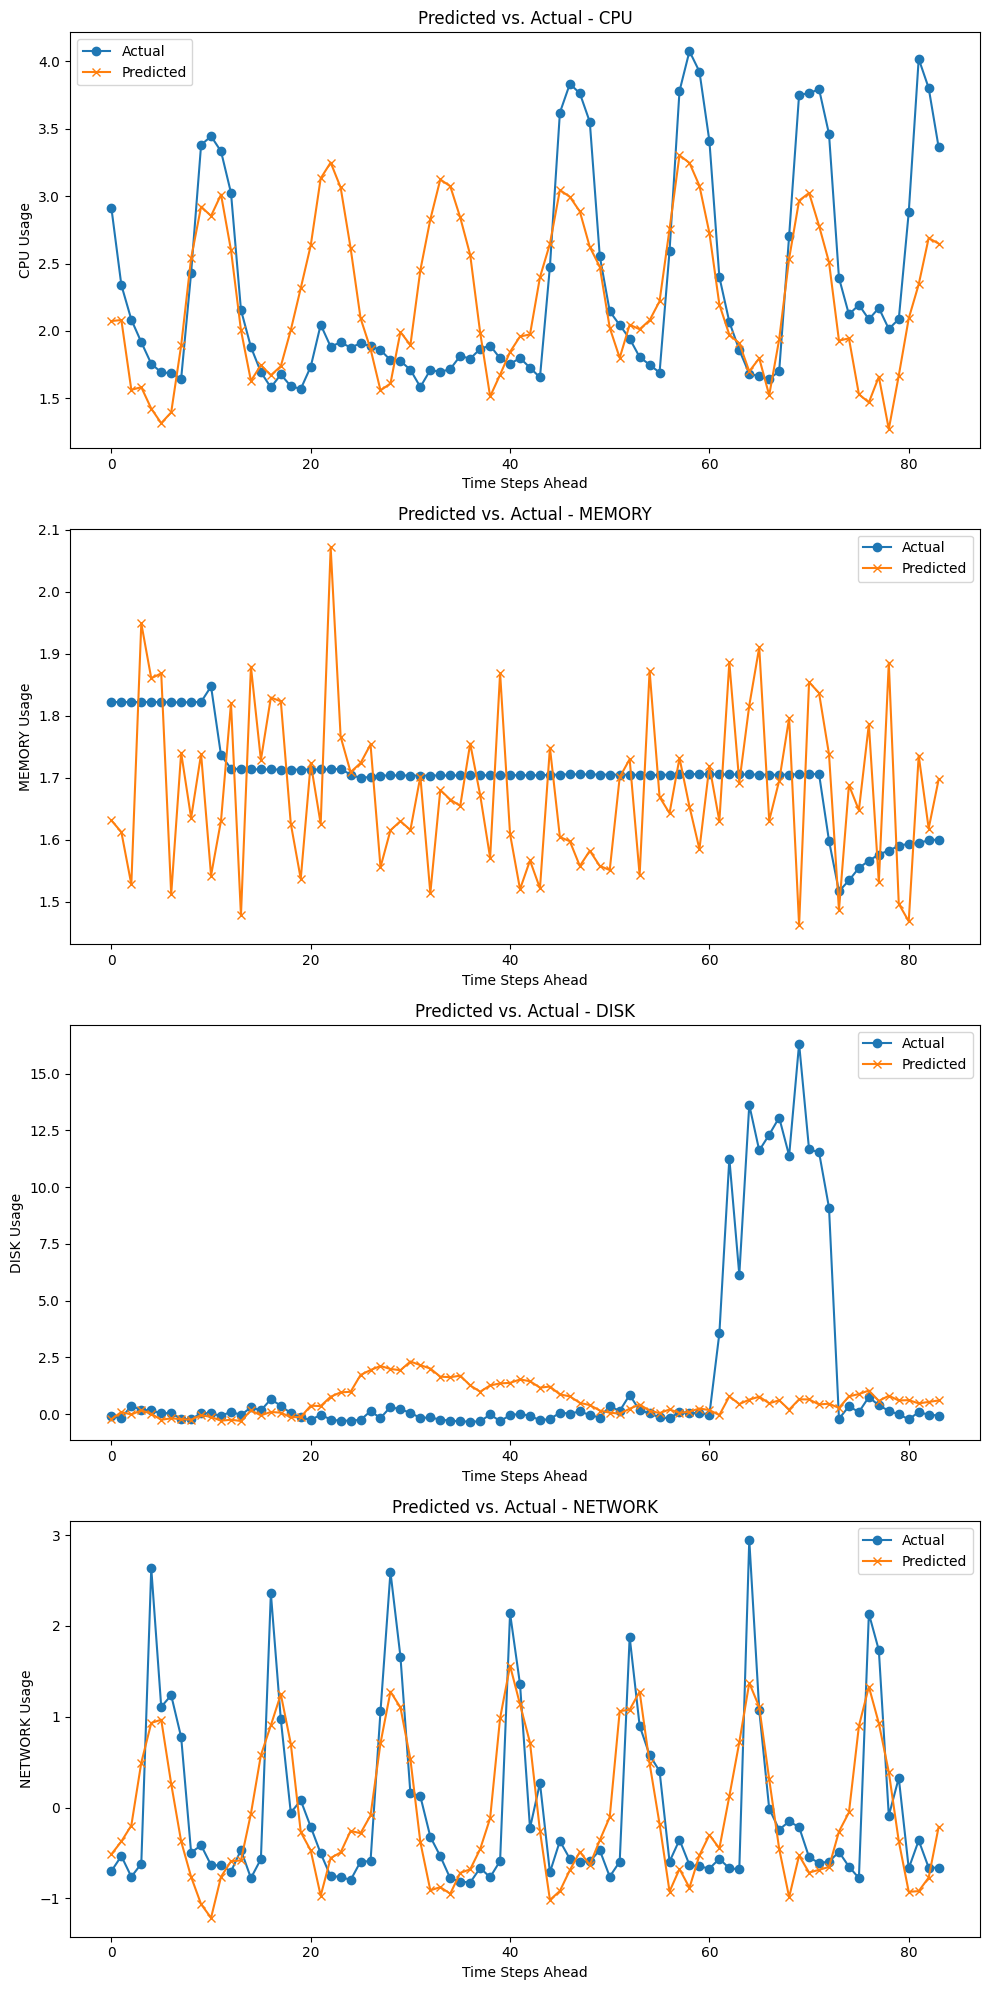

In [301]:
import matplotlib.pyplot as plt
import numpy as np

# Select a random sample from X_train
sample_idx = 322
sample_input = X_train[sample_idx:sample_idx+1]  # Pick one example
actual_output = y_train[sample_idx]  # Corresponding true values

# Make predictions
predicted_output = model.predict(sample_input)

# Reshape for visualization
actual_output = actual_output.reshape(FORECAST_HORIZON, NUM_FEATURES)
predicted_output = predicted_output.reshape(FORECAST_HORIZON, NUM_FEATURES)

# Plot each feature separately
fig, axes = plt.subplots(NUM_FEATURES, 1, figsize=(10, 5 * NUM_FEATURES))

feature_names = ["CPU", "MEMORY", "DISK", "NETWORK"]  # Adjust if needed

for i in range(NUM_FEATURES):
    ax = axes[i] if NUM_FEATURES > 1 else axes
    ax.plot(actual_output[:, i], label="Actual", marker="o")
    ax.plot(predicted_output[:, i], label="Predicted", marker="x")
    ax.set_xlabel("Time Steps Ahead")
    ax.set_ylabel(f"{feature_names[i]} Usage")
    ax.set_title(f"Predicted vs. Actual - {feature_names[i]}")
    ax.legend()

plt.tight_layout()
plt.show()


In [350]:
# Read the CSV file with timestamp parsing
test_df = pd.read_csv(f'{PROCESSED_AZURE_DATA_PATH}azure.csv', parse_dates=['timestamp'])

# Clean column names
test_df.columns = test_df.columns.str.strip().str.replace(' ', '_')

# Set the timestamp as the index
test_df.set_index('timestamp', inplace=True)

# Resample the data to 2-hour intervals (using mean aggregation)
test_df_resampled = test_df.resample('2H').max().dropna()

# Define required features and add missing ones as zeros
required_features = ["max_cpu", "MEMORY_USAGE_KB", "AVG_DISK_IO_RATE_KBPS", "AVG_NETWORK_TR_KBPS"]
test_df_resampled = test_df_resampled.reindex(columns=required_features, fill_value=0)  # Fill missing with 0

# Rename avg_cpu to match the model's input CPU_USAGE_MHZ
test_df_resampled.rename(columns={"max_cpu": "CPU_USAGE_MHZ"}, inplace=True)

In [351]:
test_df_resampled

,CPU_USAGE_MHZ,MEMORY_USAGE_KB,AVG_DISK_IO_RATE_KBPS,AVG_NETWORK_TR_KBPS
timestamp,,,,
2017-01-01 00:00:00,2.284282e+06,0,0,0
2017-01-01 02:00:00,2.152494e+06,0,0,0
2017-01-01 04:00:00,2.146585e+06,0,0,0
2017-01-01 06:00:00,2.183444e+06,0,0,0
2017-01-01 08:00:00,2.181226e+06,0,0,0
...,...,...,...,...
2017-01-30 14:00:00,2.541328e+06,0,0,0
2017-01-30 16:00:00,2.617271e+06,0,0,0
2017-01-30 18:00:00,2.559966e+06,0,0,0


In [352]:
# divide data by 100 to normalize
test_df_resampled = test_df_resampled / 100

In [353]:
# Normalize test data using MinMaxScaler
test_scaled = scaler.transform(test_df_resampled)

# Convert to DataFrame to keep column names
test_scaled_df = pd.DataFrame(test_scaled, index=test_df_resampled.index, columns=test_df_resampled.columns)
test_scaled_df

,CPU_USAGE_MHZ,MEMORY_USAGE_KB,AVG_DISK_IO_RATE_KBPS,AVG_NETWORK_TR_KBPS
timestamp,,,,
2017-01-01 00:00:00,-0.322264,-1.027608,-0.695725,-0.92467
2017-01-01 02:00:00,-0.366371,-1.027608,-0.695725,-0.92467
2017-01-01 04:00:00,-0.368348,-1.027608,-0.695725,-0.92467
2017-01-01 06:00:00,-0.356012,-1.027608,-0.695725,-0.92467
2017-01-01 08:00:00,-0.356755,-1.027608,-0.695725,-0.92467
...,...,...,...,...
2017-01-30 14:00:00,-0.236234,-1.027608,-0.695725,-0.92467
2017-01-30 16:00:00,-0.210817,-1.027608,-0.695725,-0.92467
2017-01-30 18:00:00,-0.229996,-1.027608,-0.695725,-0.92467


In [354]:
# Save test data to file as pandas
test_scaled_df.to_parquet(f'{PROCESSED_AZURE_DATA_PATH}azure.parquet')

7/7 [==============================] - 0s 45ms/step


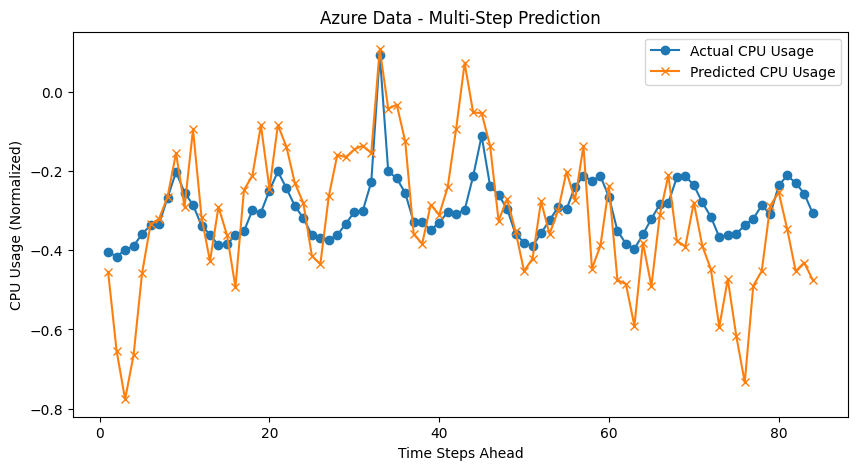

In [355]:
# Generate sequences for testing
X_test, y_test = create_multi_feature_sequences(test_scaled_df, SEQ_LENGTH, FORECAST_HORIZON)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Extract only the last sequence's prediction for comparison
y_pred_last = y_pred_scaled[-1, :, 0]  # Last test sequence's predicted CPU values

# Extract actual CPU values for the last forecast horizon steps
y_actual = y_test[-1, :, 0]  # Last test sequence's actual CPU values

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(range(1, FORECAST_HORIZON + 1), y_actual, label="Actual CPU Usage", marker="o")
plt.plot(range(1, FORECAST_HORIZON + 1), y_pred_last, label="Predicted CPU Usage", marker="x")
plt.xlabel("Time Steps Ahead")
plt.ylabel("CPU Usage (Normalized)")
plt.title("Azure Data - Multi-Step Prediction")
plt.legend()
plt.show()